In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


We are refining the main dataset to address a clear business objective: building a model that predicts a student's final academic outcome. To do this effectively, the model must be trained on data with confirmed, historical results. The records for students who are still 'Enrolled' represent an uncertain, in-progress status, not a final outcome. Including this ambiguity would introduce noise and compromise the model's ability to learn the distinct patterns that differentiate between students who ultimately Graduate and those who Dropout.

The exported file containing the 'Enrolled' students is preserved for the model's primary application. After our model is trained and validated on the historical data, we will use it to predict the future outcomes for this 'Enrolled' cohort. This allows us to generate a dropout risk score for each currently active student, enabling the institution to proactively identify at-risk individuals and implement targeted interventions to improve retention.


In [2]:
df = pd.read_csv('./data/dataset.csv')

enrolled_df = df[df['Target'] == 'Enrolled'].copy()
enrolled_df.to_csv('./data/enrolled_students.csv', index=False)

df = df[df['Target'] != 'Enrolled']
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64

In [10]:
df['Course'].value_counts()

Course
12    666
10    313
15    297
9     272
6     262
14    220
17    214
11    211
3     194
5     184
2     178
4     173
16    142
8     120
7     106
13     69
1       9
Name: count, dtype: int64

In [12]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

## Data Description

### Student & Application Data

- **Marital status**
    What it is: The student's marital situation (e.g., single, married, divorced).
    How to use it: To see if life responsibilities associated with different marital statuses correlate with academic performance or dropout. For instance, married students might have more external commitments.

- **Application mode**
    What it is: The method through which the student applied (e.g., general regime, special contests for older students, transfer).
    How to use it: To analyze if students coming from different application channels have different success rates. This can reflect their initial preparedness, motivation, or background.

- **Application order**
    What it is: The student's preference order for the course. A value of '1' means it was their first choice.
    How to use it: A powerful indicator of motivation. Students enrolled in their first-choice course are likely more committed and may have a lower dropout risk than those enrolled in a 5th or 6th choice.

- **Course**
    What it is: The specific undergraduate degree program the student is enrolled in (e.g., Nursing, Design, Agronomy).
    How to use it: To identify which courses have higher or lower dropout rates. This can point to issues like curriculum difficulty, department resources, or alignment with job market expectations.

- **Daytime/evening attendance**
    What it is: Indicates whether the student attends classes during the day or at night.
    How to use it: Evening students often have full-time jobs. This feature is critical for analyzing if the pressure of balancing work and study leads to a higher dropout rate.

- **Previous qualification**
    What it is: The student's educational qualification before enrolling in this degree (e.g., high school, another degree).
    How to use it: To assess if the type or level of prior education influences academic success.

- **Nacionality** (Note: Likely a typo for Nationality)
    What it is: The student's country of origin.
    How to use it: To compare the performance of domestic students versus those from other countries. It's often used alongside the International flag.

- **International**
    What it is: A simple flag (Yes/No) indicating if the student is an international student.
    How to use it: To analyze the specific challenges international students might face (e.g., language barriers, cultural adaptation, visa issues) and their impact on retention.

### Socio-Economic & Personal Background

- **Mother's qualification & Father's qualification**
    What they are: The highest educational level achieved by the student's parents.
    How to use them: As a proxy for socio-economic status and the value placed on education within the family. Higher parental education might correlate with a stronger support system and lower dropout rates.

- **Mother's occupation & Father's occupation**
    What they are: The professional field of the student's parents.
    How to use them: Provides further insight into a student's socio-economic background, which can influence their financial stability and access to resources.

- **Displaced**
    What it is: Indicates if the student had to move from their home region to attend the institution.
    How to use it: To analyze if students who are geographically displaced face more challenges, such as a weaker social support network or higher living costs, that could increase dropout risk.

- **Gender**
    What it is: The student's gender.
    How to use it: To analyze if there are gender-based differences in performance or dropout rates, either overall or within specific courses.

- **Age at enrollment**
    What it is: The student's age when they first enrolled in the course.
    How to use it: To compare the outcomes of traditional-age students versus mature students. Mature students might be more motivated but also face more external commitments (work, family).

### Financial & Support Status

- **Scholarship holder**
    What it is: Indicates if the student has a scholarship.
    How to use it: This can be a dual indicator. It suggests academic merit but also potential financial need. Scholarships can reduce financial pressure, thus lowering dropout risk.

- **Debtor**
    What it is: Indicates if the student has outstanding financial debts with the institution.
    How to use it: A very strong potential predictor of dropout. It is a direct signal of financial hardship.

- **Tuition fees up to date**
    What it is: Indicates if the student's tuition payments are current.
    How to use it: Similar to Debtor, this is a direct and critical indicator of financial stress, a major factor in student dropout.

- **Educational special needs**
    What it is: Indicates if the student has a registered special educational need.
    How to use it: To assess whether these students face additional challenges and to evaluate the effectiveness of the institution's support systems.

### Academic Performance (The Strongest Predictors)

- **Curricular units 1st/2nd sem (credited)**
    What it is: The number of course units from previous qualifications that were officially recognized.
    How to use it: A high number could mean a student is well-prepared, but it could also indicate a transfer student who may have struggled elsewhere.

- **Curricular units 1st/2nd sem (enrolled)**
    What it is: The number of course units the student signed up for in the semester.
    How to use it: Measures the student's intended academic load. A very high or very low number could be a sign of being over-ambitious or disengaged.

- **Curricular units 1st/2nd sem (evaluations)**
    What it is: The number of assessments (exams, projects) the student participated in.
    How to use it: Comparing this to the enrolled units is key. A large gap indicates a student is not attending classes or submitting work, a major red flag for dropout.

- **Curricular units 1st/2nd sem (without evaluations)**
    What it is: The number of enrolled courses in which the student had zero evaluations.
    How to use it: This is a direct measure of non-participation and a very strong predictor of dropout.

- **Curricular units 1st/2nd sem (approved)**
    What it is: The number of course units the student successfully passed in the semester.
    How to use it: One of the most powerful predictors. It is a direct measure of academic success. A low approval rate is a clear indicator of academic difficulty and high dropout risk.

- **Curricular units 1st/2nd sem (grade)**
    What it is: The student's average grade for the semester.
    How to use it: Along with approved units, this is a core indicator of academic performance. Low grades consistently predict a higher likelihood of dropping out.

### Macroeconomic Context

- **Unemployment rate, Inflation rate, GDP**
    What they are: Economic indicators for the region at the time of the student's enrollment/semester.
    How to use them: To understand how the external economic environment affects student decisions. For example, high unemployment might make higher education seem more attractive (fewer jobs available) but also make it harder for families to afford tuition.

### The Outcome Variable

- **Target**
    What it is: The final status of the student at the end of the data collection period. It has three possible values: Dropout, Graduate, or Enrolled.
    How to use it: This is the dependent variable. Your goal is to use all the other features as predictors to build a model that can accurately classify a student into one of these three outcomes.

## Basic Pre-processing steps

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3630 non-null   int64  
 1   Application mode                                3630 non-null   int64  
 2   Application order                               3630 non-null   int64  
 3   Course                                          3630 non-null   int64  
 4   Daytime/evening attendance                      3630 non-null   int64  
 5   Previous qualification                          3630 non-null   int64  
 6   Nacionality                                     3630 non-null   int64  
 7   Mother's qualification                          3630 non-null   int64  
 8   Father's qualification                          3630 non-null   int64  
 9   Mother's occupation                           

In [3]:
X = df.drop('Target', axis=1)
y = df['Target'].map({'Dropout': 1, 'Graduate': 0})
y.name = 'Target'

In [4]:
cols_to_convert_to_category = [
    'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
    'Previous qualification', 'Nacionality', "Mother's qualification", 
    "Father's qualification", "Mother's occupation", "Father's occupation", 
    'Displaced', 'Educational special needs', 'Debtor', 
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

for col in cols_to_convert_to_category:
    if col in X.columns:
        X[col] = X[col].astype('category')


In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  3630 non-null   category
 1   Application mode                                3630 non-null   category
 2   Application order                               3630 non-null   int64   
 3   Course                                          3630 non-null   category
 4   Daytime/evening attendance                      3630 non-null   category
 5   Previous qualification                          3630 non-null   category
 6   Nacionality                                     3630 non-null   category
 7   Mother's qualification                          3630 non-null   category
 8   Father's qualification                          3630 non-null   category
 9   Mother's occupation                

## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Engineering

In [6]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Versão final e robusta da classe de feature engineering.
    - Corrige os FutureWarnings do pandas para compatibilidade futura.
    """
    def __init__(self, rare_threshold=0.01):
        self.rare_threshold = rare_threshold

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='Target')
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        if not is_numeric_dtype(y):
            raise TypeError("A variável alvo 'y' deve ser numérica (0s e 1s).")
        
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.ohe_cols_ = []
        self.target_cols_ = []
        for col in categorical_cols:
            n_unique = X[col].nunique()
            if 2 <= n_unique <= 5:
                self.ohe_cols_.append(col)
            elif n_unique >= 6:
                self.target_cols_.append(col)
        
        self.target_maps_ = {}
        self.global_mean_ = y.mean()
        for col in self.target_cols_:
            self.target_maps_[col] = pd.concat([X[col], y], axis=1).groupby(col, observed=False)[y.name].mean()

        self.rare_categories_ = {}
        self.high_cardinality_for_rare_ = []
        high_cardinality_cols = [col for col in self.target_cols_ if X[col].nunique() > 15]
        for col in high_cardinality_cols:
            counts = X[col].value_counts(normalize=True)
            self.rare_categories_[col] = counts[counts < self.rare_threshold].index.tolist()
            # Guarda as colunas que terão categorias raras agrupadas
            if len(self.rare_categories_[col]) > 0:
                self.high_cardinality_for_rare_.append(col)
        
        temp_transformed_df = self.transform(X.head(2).copy())
        self.final_columns_ = temp_transformed_df.columns.tolist()
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Criação de Novas Features
        X_transformed['taxa_sucesso_1sem'] = (X_transformed['Curricular units 1st sem (approved)'] / X_transformed['Curricular units 1st sem (enrolled)']).fillna(0)
        X_transformed['taxa_sucesso_2sem'] = (X_transformed['Curricular units 2nd sem (approved)'] / X_transformed['Curricular units 2nd sem (enrolled)']).fillna(0)
        X_transformed['progresso_academico_taxa'] = X_transformed['taxa_sucesso_2sem'] - X_transformed['taxa_sucesso_1sem']
        
        total_enrolled_year1 = X_transformed['Curricular units 1st sem (enrolled)'] + X_transformed['Curricular units 2nd sem (enrolled)']
        total_without_evals_year1 = X_transformed['Curricular units 1st sem (without evaluations)'] + X_transformed['Curricular units 2nd sem (without evaluations)']
        X_transformed['taxa_desistencia_disciplinas'] = (total_without_evals_year1 / total_enrolled_year1).fillna(0)
        
        X_transformed['indice_pressao_financeira'] = X_transformed['Debtor'].astype(int) + (1 - X_transformed['Tuition fees up to date'].astype(int))
        
        # Discretização da Idade
        age_bins = [0, 18, 25, 40, 100]
        age_labels = ['Adolescente', 'Jovem Adulto', 'Adulto', 'Maduro']
        X_transformed['faixa_etaria'] = pd.cut(X_transformed['Age at enrollment'], bins=age_bins, labels=age_labels, right=False).astype('object')
        
        # Processamento Categórico
        for col in self.high_cardinality_for_rare_:
            rare_list = self.rare_categories_[col]
            if 'Other' not in X_transformed[col].cat.categories:
                X_transformed[col] = X_transformed[col].cat.add_categories('Other')
            X_transformed[col] = X_transformed[col].replace(rare_list, 'Other')
            
        # Target Encoding
        if hasattr(self, 'target_maps_'):
            for col, mapping in self.target_maps_.items():
                X_transformed[col + '_encoded'] = X_transformed[col].astype(str).map(mapping).fillna(self.global_mean_)
        
        # One-Hot Encoding
        cols_for_ohe_final = self.ohe_cols_ + ['faixa_etaria']
        ohe_df = pd.get_dummies(X_transformed[cols_for_ohe_final], prefix_sep='_')

        # Combinação e Limpeza Final
        target_encoded_features = [col + '_encoded' for col in self.target_cols_ if hasattr(self, 'target_maps_')]
        X_transformed = X_transformed.drop(columns=self.ohe_cols_ + self.target_cols_, errors='ignore')
        X_transformed = pd.concat([X_transformed, ohe_df], axis=1)

        cols_to_drop = [
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (grade)',
            'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)',
            'Debtor', 'Tuition fees up to date', 'Age at enrollment'
        ]
        numeric_cols_original = X.select_dtypes(include=np.number).columns.tolist()
        new_numeric_features = ['taxa_sucesso_1sem', 'taxa_sucesso_2sem', 'progresso_academico_taxa', 'taxa_desistencia_disciplinas', 'indice_pressao_financeira']
        
        final_df = pd.concat([
            X_transformed[numeric_cols_original].drop(columns=cols_to_drop, errors='ignore'), 
            X_transformed[new_numeric_features],
            X_transformed[target_encoded_features],
            ohe_df
        ], axis=1)
        
        if hasattr(self, 'final_columns_'):
            missing_cols = set(self.final_columns_) - set(final_df.columns)
            for c in missing_cols:
                final_df[c] = 0
            return final_df[self.final_columns_]

        return final_df

## Model Selection

In [7]:
def compute_class_weights(y):
    class_counts = pd.Series(y).value_counts().sort_index()
    total = len(y)
    weights = total / (len(class_counts) * class_counts)
    return weights.tolist()


In [9]:
preprocessing_pipeline = SklearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('feature_selection', SmartCorrelatedSelection(threshold=0.8, selection_method='variance'))
])

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

models_with_class_weight = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Ridge Classifier": RidgeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True, random_state=42),
    "Linear SVM": LinearSVC(class_weight='balanced', random_state=42),
    "Perceptron": Perceptron(class_weight='balanced', random_state=42),
    "Passive Aggressive": PassiveAggressiveClassifier(class_weight='balanced', random_state=42),
    "HistGBM": HistGradientBoostingClassifier(class_weight='balanced', random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        class_weights=compute_class_weights(y_train),
        verbose=0,
        random_state=42
    ),
}

models_for_adasyn = {
    "MLP Classifier": MLPClassifier(max_iter=500, random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis()
}

cv_predictions_df = pd.DataFrame({'y_real': y_train.copy()})
f1_scores = {}

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(">>> GERANDO PREVISÕES DE CV: MODELOS COM BALANCEAMENTO INTERNO <<<")
for name, model in models_with_class_weight.items():
    full_pipeline = SklearnPipeline(steps=[('preprocessing', preprocessing_pipeline), ('classifier', model)])
    
    print(f"Processando: {name}...")
    # Usamos cross_val_predict para obter as previsões
    predictions = cross_val_predict(full_pipeline, X_train, y_train, cv=cross_validation)
    cv_predictions_df[name] = predictions
    
    f1 = cross_val_score(full_pipeline, X_train, y_train, cv=cross_validation,
                         scoring=make_scorer(f1_score))
    
    f1_scores[name] = (np.mean(f1), np.std(f1))

print("\n>>> GERANDO PREVISÕES DE CV: MODELOS COM ADASYN <<<")
for name, model in models_for_adasyn.items():
    full_pipeline_adasyn = ImblearnPipeline(steps=
        preprocessing_pipeline.steps + 
        [
            ('resampling', ADASYN(random_state=42)),
            ('classifier', model)
        ]
    )
    print(f"Processando: {name}...")
    predictions = cross_val_predict(full_pipeline_adasyn, X_train, y_train, cv=cross_validation)
    cv_predictions_df[name] = predictions
    
    f1 = cross_val_score(full_pipeline_adasyn, X_train, y_train, cv=cross_validation,
                         scoring=make_scorer(f1_score))
    f1_scores[name] = (np.mean(f1), np.std(f1))

print("\n>>> GERANDO PREVISÕES DE CV: MODELOS POLINOMIAIS <<<")

for degree in range(2, 3):
    name = f"Polynomial Logistic Regression (deg {degree})"
    poly_pipeline = SklearnPipeline(steps=[
        ('feature_engineering', FeatureEngineer()),
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('feature_selection', SmartCorrelatedSelection(threshold=0.8, selection_method='variance')),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ])

    print(f"Processando: {name}...")
    predictions = cross_val_predict(poly_pipeline, X_train, y_train, cv=cross_validation)
    cv_predictions_df[name] = predictions
    
    f1 = cross_val_score(poly_pipeline, X_train, y_train, cv=cross_validation,
                         scoring=make_scorer(f1_score))
    f1_scores[name] = (np.mean(f1), np.std(f1))

print("\n>>> Coleta de previsões de validação cruzada concluída.")

>>> GERANDO PREVISÕES DE CV: MODELOS COM BALANCEAMENTO INTERNO <<<
Processando: Logistic Regression...
Processando: Ridge Classifier...
Processando: Random Forest...
Processando: Extra Trees...
Processando: Decision Tree...
Processando: Support Vector Machine...
Processando: Linear SVM...
Processando: Perceptron...
Processando: Passive Aggressive...
Processando: HistGBM...
Processando: LightGBM...
Processando: XGBoost...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:13:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:13:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:13:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:13:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_en

Processando: AdaBoost...
Processando: CatBoost...

>>> GERANDO PREVISÕES DE CV: MODELOS COM ADASYN <<<
Processando: MLP Classifier...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

Processando: Gaussian Naive Bayes...
Processando: KNN...
Processando: LDA...
Processando: QDA...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: 


>>> GERANDO PREVISÕES DE CV: MODELOS POLINOMIAIS <<<
Processando: Polynomial Logistic Regression (deg 2)...

>>> Coleta de previsões de validação cruzada concluída.


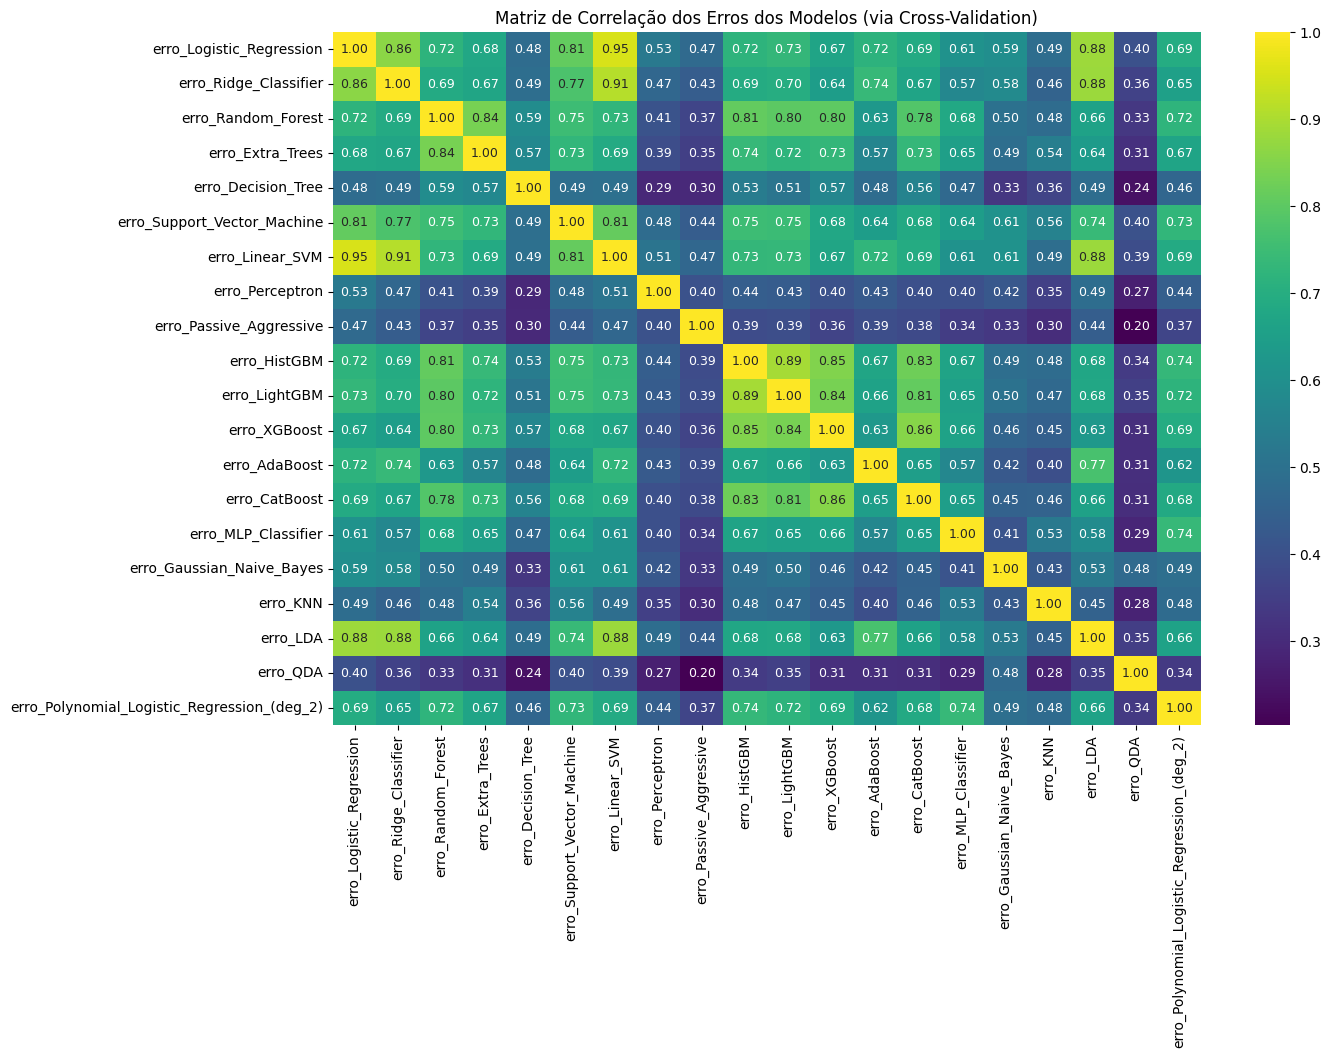

In [55]:
# Criar colunas booleanas de erro (True se errou, False se acertou)
error_cols = []
all_model_names = list(models_with_class_weight.keys()) + list(models_for_adasyn.keys()) + [f"Polynomial Logistic Regression (deg {degree})" for degree in range(2, 3)]

for name in all_model_names:
    error_col_name = f"erro_{name.replace(' ', '_')}"
    cv_predictions_df[error_col_name] = (cv_predictions_df[name] != cv_predictions_df['y_real'])
    error_cols.append(error_col_name)

# Calcular a matriz de correlação dos erros
error_correlation = cv_predictions_df[error_cols].corr()

# Visualizar a matriz com um heatmap
plt.figure(figsize=(14, 9))
sns.heatmap(error_correlation, annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 9})
plt.title('Matriz de Correlação dos Erros dos Modelos (via Cross-Validation)')
plt.show()

In [10]:
for model, (mean, std) in f1_scores.items():
    print(f"{model}: F1 Score = {mean:.4f} ({std:.4f})")

Logistic Regression: F1 Score = 0.8534 (0.0095)
Ridge Classifier: F1 Score = 0.8519 (0.0160)
Random Forest: F1 Score = 0.8658 (0.0105)
Extra Trees: F1 Score = 0.8575 (0.0089)
Decision Tree: F1 Score = 0.8108 (0.0108)
Support Vector Machine: F1 Score = 0.8574 (0.0147)
Linear SVM: F1 Score = 0.8543 (0.0124)
Perceptron: F1 Score = 0.7878 (0.0243)
Passive Aggressive: F1 Score = 0.7603 (0.0346)
HistGBM: F1 Score = 0.8711 (0.0131)
LightGBM: F1 Score = 0.8751 (0.0136)
XGBoost: F1 Score = 0.8661 (0.0098)
AdaBoost: F1 Score = 0.8273 (0.0092)
CatBoost: F1 Score = 0.8658 (0.0132)
MLP Classifier: F1 Score = 0.8357 (0.0051)
Gaussian Naive Bayes: F1 Score = 0.7669 (0.0627)
KNN: F1 Score = 0.7776 (0.0107)
LDA: F1 Score = 0.8559 (0.0125)
QDA: F1 Score = 0.7509 (0.0984)
Polynomial Logistic Regression (deg 2): F1 Score = 0.8534 (0.0100)


## Stacking Ensemble

In [8]:
pipeline_lgbm = SklearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('feature_selection', SmartCorrelatedSelection(threshold=0.8, selection_method='variance')),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=42, verbosity=-1))
])

pipeline_lda = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('feature_selection', SmartCorrelatedSelection(threshold=0.8, selection_method='variance')),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
])


# pipeline_svc = SklearnPipeline(steps=[
#     ('feature_engineering', FeatureEngineer()),
#     ('scaler', StandardScaler()),
#     ('feature_selection', SmartCorrelatedSelection(threshold=0.8, selection_method='variance')),
#     ('classifier', SVC(class_weight='balanced', probability=True, random_state=42))
# ])

pipeline_poly = SklearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('feature_selection', SmartCorrelatedSelection(threshold=0.8, selection_method='variance')),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

estimators = [
    ('lightgbm', pipeline_lgbm),
    # ('svc', pipeline_svc),
    ('lda_with_adasyn', pipeline_lda),
    ('polynomial_classifier', pipeline_poly)
]

meta_classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=5
)

In [15]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(stacking_model, X_train, y_train, cv=cross_validation, scoring='balanced_accuracy')

In [16]:
print(f"F1-Score Médio (CV=5): {np.mean(scores):.4f}")  
print(f"Desvio Padrão dos Scores: {np.std(scores):.4f}")

F1-Score Médio (CV=5): 0.8861
Desvio Padrão dos Scores: 0.0050


## Hyperparameter Tuning

In [ ]:
search_space = {
    'lightgbm__classifier__n_estimators': Integer(100, 800),
    'lightgbm__classifier__learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'lightgbm__classifier__num_leaves': Integer(20, 50),
    
    'lda_with_adasyn__classifier__solver': Categorical(['lsqr', 'eigen']),
    # O shrinkage só funciona com os solvers 'lsqr' e 'eigen'
    'lda_with_adasyn__classifier__shrinkage': Real(0.0, 1.0), 

    'polynomial_classifier__classifier__C': Real(0.1, 100.0, 'log-uniform'),
    'polynomial_classifier__poly_features__degree': Integer(2, 3),

    'final_estimator__C': Real(0.1, 100.0, 'log-uniform')
}

search_cv = BayesSearchCV(
    estimator=stacking_model,
    search_spaces=search_space,
    n_iter=10,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1
)

search_cv.fit(X_train, y_train)

print("\n--- Resultados do Fine-Tuning ---")
print(f"Melhor F1-Score (CV=3) encontrado: {search_cv.best_score_:.4f}")
print("\nMelhores Hiperparâmetros encontrados:")

for param, value in search_cv.best_params_.items():
    print(f"- {param}: {value}")

best_stacking_model = search_cv.best_estimator_

/tmp/ipykernel_153532/2183131065.py:71: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/tmp/ipykernel_153532/2183131065.py:71: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/tmp/ipykernel_153532/2183131065.py:71: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/tmp/ipykernel_153532/2183131065.py:71: FutureWarning: The behavior of Series.replace (and DataFrame.re